# Example: Modeling the Payout and Profit of Long and Short American-style Call Contracts

## Background
A `call` option is a financial contract that gives the holder the right, but not the obligation, to purchase a specified asset, such as stocks, commodities, or currencies, at a predetermined price within a specified time period. Let's consider stock as the underlying asset. A single standard `call` contract controls `100` shares of stock.

The business case for buying (or selling) a `call` contract:
* __Buyer (long)__: From the buyer's perspective, call contracts allow an investor to benefit from the price movement of `XYZ` to the upside _without_ purchasing `XYZ`. Further, call options (again from the buyer's perspective) have _limited downside risk_, i.e., the maximum amount that the holder of the call option can lose is the premium paid for the option. Finally, call options are a mechanism to purchase shares of `XYZ` at the strike price of $K$ instead of the market price of $S$. 
* __Seller (short)__: From the seller's perspective, the main objective of selling a call contract is to collect the premium $\mathcal{P}$. Call contracts also allow the seller to benefit from the price movement of `XYZ` to the downside _without_ purchasing `XYZ`. However, for a seller, call options have _unlimted upside_ risk; thus, call options are often only sold by investors who already own the required number of shares of `XYZ` (known as a [covered call position](https://www.investopedia.com/terms/c/coveredcall.asp)). Finally, call options offer the seller the opportunity to sell shares of `XYZ` at the strike price of $K$ instead of the market price of $S$.

In the case of [American](https://www.investopedia.com/terms/a/americanoption.asp) style [call contracts](https://www.investopedia.com/terms/p/putoption.asp), the option buyer can exercise their right at any point between when the contract is purchased and the expiration date. On the other hand, buyers of [European](https://www.investopedia.com/terms/e/europeanoption.asp) style contracts can only exercise their right on the expiration date.

## Payoff, Profit, Premium and Breakeven
The payoff per share of a `call` contract at expiration `T` days in the future $V_{c}(K,S(T))$ is defined as:

$$V_{c}(K,S(T)) = (S-K)^{+} = \max\left(S(T) - K,~0\right)$$

where $K$ denotes the strike price and $S(T)$ represents the share price of the underlying asset `T` days in the future (at expiration). The right (but not the obligation) to buy shares at the strike `K` is not free. The contract `seller` charges the contract `buyer` a premium for each `call` contract $\mathcal{P}_{c}(\dots)$. From the perspective of the `buyer`, the profit per share for the `call` contract $P_{c}$ is the payoff of the contract minus the cost of the contract:

$$P_{c}(K,S(T)) = V_{c}(K,S(T)) -  \mathcal{P}_{c}(K,S(0))$$

Thus, from the buyer’s perspective, the share price must fall _above the strike price_ to make up the amount paid for the contract which is called the breakeven price $\mathcal{B}_{c}$:

$$\mathcal{B}_{c} = K + \mathcal{P}_{c}(K,S(0))$$

Finally, the premium (cost) for each `call` contract $\mathcal{P}_{c}(\dots)$ is defined by the expression:

$$\mathcal{P}_{c}(K,S(0))\geq\mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{c}}(K,S(T)\Bigr)$$

where $\mathcal{D}_{T,0}(\bar{r})$ denotes the discount rate between the time when the contract was purchased `0` and contract expiration `T` days in the future. Option contracts use risk-neutral pricing; thus, the discount rate $\bar{r}$ is typically taken as the interest rate on 10-year treasury notes. 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages

The `Include.jl` file loads several packages that we use'll for our exercises:

* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality.

### Types

`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the excercises.

The `MyEuropeanPutContractModel` and `MyEuropeanCallContractModel` types encode information about European `put` and `call` contracts:
* The field `K::Float64` is the strike price of the `put` (or `call`) contract
* The field `sense::Int64` encodes if the contract was sold (`sense = -1` short) or purcahsed (`sense = 1` long). 
* The `DTE::Float64` field encodes the number of days to expiration (DTE) of the contract
* The `IV::Float64` field encodes the implied volatility, i.e., the share price volatility of the underlying asset for this `put` or `call` contract
* The `premium::Union{Nothing, Float64}` field is the cost of the contract (what we'll be calculating in this example)
* The `ticker::Union{Nothing,String}` field encodes the symbol for a `put` or `call` contract, see [How to Read a Stock Options Ticker](https://polygon.io/blog/how-to-read-a-stock-options-ticker/).

The `MyAmericanPutContractModel` and `MyAmericanCallContractModel` types encode information about American `put` and `call` contracts:
* The field `K::Float64` is the strike price of the `put` (or `call`) contract
* The field `sense::Int64` encodes if the contract was sold (`sense = -1` short) or purcahsed (`sense = 1` long). 
* The `DTE::Float64` field encodes the number of days to expiration (DTE) of the contract
* The `IV::Float64` field encodes the implied volatility, i.e., the share price volatility of the underlying asset for this `put` or `call` contract
* The `premium::Union{Nothing, Float64}` field is the cost of the contract (what we'll be calculating in this example)
* The `ticker::Union{Nothing,String}` field encodes the symbol for a `put` or `call` contract, see [How to Read a Stock Options Ticker](https://polygon.io/blog/how-to-read-a-stock-options-ticker/).

The `MyGeometricBrownianMotionEquityModel` type encodes data used to simulate the future share price of an underlying asset assuming the share price is described by [geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion).

* The `μ::Float64` field encodes the drift parameter for the share price (in this case the risk free rate).
* The `σ::Float64` field encodes the volatility parameter for the share price (in this case the [implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) of `IV`). 

The `MyBlackScholesContractPricingModel` type encodes data used to compute the price of European option contracts using the [Black–Scholes pricing formula](https://en.wikipedia.org/wiki/Black–Scholes_model):
* The field `r::Float64` holds the risk free rate, the discount rate used in risk-neutral contract pricing
* The field `Sₒ::Float64` holds the current share of the underlying asset

The `MyAdjacencyBasedCRREquityPriceTree` type encoded data required to compute the price of an American `call` or `put` contract price using the Bionomial lattice model of Cox, Ross and Rubinstein:
* The `data::Dict{Int, MyCRRLatticeNodeModel}` field holds a `Dict` where the node indexes are the `keys` and `MyCRRLatticeNodeModel` are the values. The `MyCRRLatticeNodeModel` type holds the `price` and `probability` of the underlying share price, along with the `intrinsic::Float64` and
    `extrinsic::Float64` value of the contract at the node index. 
* The `connectivity::Dict{Int64, Array{Int64,1}}` holds a `Dict` which holds connectivity information about the nodes in the lattice
* The `levels::Dict{Int64,Array{Int64,1}}` field the node indexes on a particular tree level
* The `u::Float64` field holds the value of the `up` factor
* The `p::Float64` field holds the probability of an `up` price move by the underlying stock
* The `ΔT::Float64` field holds the length of the time step in the lattice
* The `μ::Float64` field holds the risk free growth rate

The `MyLongstaffSchwartzContractPricingModel` type holds data required to compute the price of American `call` and `put` options using the Longstaff and Schwartz Least Squares method (LSM) pricing method:
* The `S::Array{Float64,2}` field holds a set of sample paths for the underlying share price, where the sample paths are on the rows, time is along the columns
* The `r̄::Float64` is the risk free rate used for risk-neutral price (the discount rate used to calculate the discount factor)
* The `Δt::Float64`field holds the length of each time step, typcially `1-day` in units of years.

### Functions

`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

#### Pricing models
`build(model::Type{MyBlackScholesContractPricingModel}, data::NamedTuple) -> MyBlackScholesContractPricingModel`.
This `build(...)` method takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyBlackScholesContractPricingModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyGeometricBrownianMotionEquityModel}, data::NamedTuple) -> MyGeometricBrownianMotionEquityModel`.
This `build(...)` method takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyGeometricBrownianMotionEquityModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyLongstaffSchwartzContractPricingModel}, data::NamedTuple) -> MyLongstaffSchwartzContractPricingModel`
This `build(...)` method takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyLongstaffSchwartzContractPricingModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(modeltype::Type{MyAdjacencyBasedCRREquityPriceTree}; h::Int = 1, μ::Float64 = 0.01, σ::Float64 = 0.1, T::Float64 = (1.0/365.0), Sₒ::Float64 = 1.0) -> MyAdjacencyBasedCRREquityPriceTree`
This `build(...)` method takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyAdjacencyBasedCRREquityPriceTree` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types), which is used for the binomial lattice prediction of option price.
    
* `h`  is the number of levels in the tree
* `T`  is the number of days (in units of years) for the contract
* `μ` is the risk free rate (annualized)
* `σ` is the implied volatility of the contract (annualized)
* `Sₒ` is the initial share price of the underlying asset

#### Monte-Carlo 

`sample_endpoint(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple; number_of_paths::Int64 = 100) -> Array{Float64,1}`.
The `sample_endpoint(...)` function takes a `MyGeometricBrownianMotionEquityModel` model instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument, and simulates the share price `T` days into the future. The simulated future share price is returned as an `Array{Float64,1}`.

#### Contracts
`build(model::Type{MyEuropeanPutContractModel}, data::NamedTuple) -> MyEuropeanPutContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyEuropeanPutContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyEuropeanCallContractModel}, data::NamedTuple) -> MyEuropeanCallContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyEuropeanCallContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyAmericanPutContractModel}, data::NamedTuple) -> MyEuropeanPutContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyAmericanPutContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

`build(model::Type{MyAmericanCallContractModel}, data::NamedTuple) -> MyEuropeanCallContractModel`. This `build(...)` method
takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and returns an instance of the `MyAmericanCallContractModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types).

#### Payoff and Proft

`payoff(contracts::Array{T,1}, S::Array{Float64,1}) -> Array{Float64,2} where T <: AbstractContractModel`. The `payoff(...)` function
takes an array of contract models and an array of share prices at expiration and returns an array of payoff values for each contract where each row holds the payoff value for a particular future share price at expiration, and each column holds the payoff value for the contracts, where the columns are in the same order as the `contracts` array.

`profit(contracts::Array{T,1}, S::Array{Float64,1}) -> Array{Float64,2} where T <: AbstractContractModel`. The `profit(...)` function takes an array of contract models and an array of share prices at expiration and returns an array of profit values for each contract.  Each row of the array holds the payoff value for a particular future share price at expiration, while each column holds the profit value for a contract (in the same order as the `contracts` array).

#### Premium
`premium(contract::MyEuropeanCallContractModel, model::MyBlackScholesContractPricingModel; sigdigits::Int64 = 4) -> Float64`. The `premium(...)` functions takes a `call` or `put` contract model, and a `pricing` model (in this case an instance of the `MyBlackScholesContractPricingModel` type) and returns the contract premium.

`premium(contract::T, model::MyAdjacencyBasedCRREquityPriceTree; choice::Function=_rational) -> Float64 where {T<:AbstractContractModel}`. This `premium(...)` method takes American `call` or `put` contract model, and binomial `pricing` model and returns the contract premium.

In [1]:
include("Include.jl");

## Learning objectives
In this example, we will be calculating the premium, profit and breakeven for sample `call` option contracts. Our focus will be on two types of contracts: [European-style contracts](https://en.wikipedia.org/wiki/Option_style), which can only be exercised at the time of expiration; and [American-style contracts](https://en.wikipedia.org/wiki/Option_style), which can be exercised at any point between purchase and expiration. 

* __Objective 1__: involves computing the premium, profit, and breakeven points for European-style contracts using both the [Monte Carlo simulation approach](https://en.wikipedia.org/wiki/Monte_Carlo_method) and the [Black-Scholes pricing formula](https://en.wikipedia.org/wiki/Black–Scholes_mode). 
* __Objective 2__: is focused on American-style `call` contracts. We will be using the [Cox, Ross, and Rubinstein (CRR) model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) to compute the premium, profit, and breakeven points. 
* __Objective 3__: will utilize the [Monte Carlo simulation method of Longstaff and Schwartz](https://en.wikipedia.org/wiki/Monte_Carlo_methods_for_option_pricing) to compute the premium for American-style `call` contracts. 

We will compare our computational results with known values to determine the effectiveness of each approach.

## Objective 1: Premium, payoff and profit for a European `call` contract

Let's begin by computing the premium $\mathcal{P}_{c}(K,S(0))$ the buyer must pay for a `call` contract. When early excersise is not allowed, the pricing formula is given by (the equality case):

$$\mathcal{P}_{c}(K,S(0)) = \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{c}}(K,S(T))\Bigr)$$

which says the right (but not the obligation) to excercise the `call` contract is the expected value of the discounted future payoff from the contract. To compute the expectation, we simulate the future share price `T` days in the future using a [geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion#:~:text=A%20geometric%20Brownian%20motion%20(GBM,a%20Wiener%20process)%20with%20drift.) model for the future share price:

$$S(T) = S(0)\cdot\exp\Biggl[\left(\bar{r}-\frac{\sigma^{2}}{2}\right)\cdot{T} + (\sigma\sqrt{T})\cdot{Z_{t}(0,1)}\Biggr]$$

where we assume $S(0)$ is the share price today, $\bar{r}$ denotes the risk-free rate (risk-neutral pricing), $\sigma$ denotes share price volatility and `T` denotes the number of days until contract expiration. Once we have the premium $\mathcal{P}_{c}(K,S(0))$ value, we can calculate (and visualize) the payoff, potential profit and breakeven values for the `call` contract.

### Implementation
Let's consider an example: We have a European `call` that expires in `T = 365` days with a strike price `K = 60.0`. The current share price is `S(0)=60.0`. Assume a risk free rate of return of `5%` and a implied volatility of `10%`. The correct answer is $\mathcal{P}_{c}(K,S(0))$ = 4.08 USD/share. Let's compute the European `call` premium using two appoaches:

* Approach 1: Monte Carlo simulation of the share price by sampling the geometric Brownian motion model, and then explicitly calculating the expectation in the pricing relationship
* Approach 2: Use the [Black–Scholes](https://en.wikipedia.org/wiki/Black–Scholes_model) pricing formula for a European `call` option

We start by defining the problem parameters that are shared between the approaches:

In [2]:
Δt = (1.0/365.0);
Sₒ = 60.0;
K = 60.0;
T = 365.0*Δt;
r̄ = 0.05;
σ̄ = 0.10;

#### Approach 1: Monte Carlo estimate of European `call` contract price
Let's build an instance of the `MyGeometricBrownianMotionEquityModel` type which holds the value for the price simulation using the `build(...)` method and store in the `model` variable:

In [3]:
model = build(MyGeometricBrownianMotionEquityModel, (
        μ = r̄, σ = σ̄));

Next, we build an instance of the `MyEuropeanCallContractModel` type which holds the parameters for the `call` contract using the `build(...)` method. We store the contract model in the `call_contract_model` variable:

In [4]:
call_contract_model = build(MyEuropeanCallContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1));

We'll simulate the future share price at expiration $S(T)$ for different number of sample paths. We'll store these values in the `number_of_samples` array:

In [5]:
number_of_samples = range(1.0,stop=5,step=1.0) |> collect |> (x-> exp10.(x)) |> (x-> 5*Int.(x));

Finally, for each number of sample paths, we sample the geometric Brownian model instance using the `sample(...)` function, compute the payoff using `payoff(...)` function, compute the premium array which is stored in the `P̄` variable, and then compute the mean `premium`  and standard error `SE` of the expected discounted future contract payoff. We propulate a `DataFrame` instance that holds the data for each number of sample paths:

In [6]:
call_price_df = DataFrame(n = Int64[], premium = Float64[], SE = Float64[], CI95 = Float64[]);
for n ∈ number_of_samples
    S = sample_endpoint(model, (T = T, Sₒ = Sₒ), number_of_paths = n);
    P = payoff([call_contract_model], S);
    P̄ = (1/𝒟(r̄,T))*P[:,3];
    mean_value = mean(P̄);
    std_error_value = (1.0/sqrt(n))*std(P̄);
    CI95_value = 1.96*std_error_value;
    
    results_df = (
        
        n = n,
        premium = mean_value,
        SE = std_error_value,
        CI95 = CI95_value
    );
    
    push!(call_price_df, results_df);
end

call_price_df

Row,n,premium,SE,CI95
,Int64,Float64,Float64,Float64
1,50,4.14033,0.65368,1.28121
2,500,4.12835,0.195313,0.382814
3,5000,4.04888,0.064553,0.126524
4,50000,4.0338,0.0205679,0.040313
5,500000,4.08326,0.00656785,0.012873


#### Approach 2: Black–Scholes pricing formula for a European `call` contract
The [Black–Scholes pricing formula ](https://en.wikipedia.org/wiki/Black–Scholes_model) for a European `call` option is given by the expression:

$$\mathcal{P}_{c}(K,S(0)) = N(d_{+})S(0) - N(d_{-})K\mathcal{D}^{-1}_{T,0}(\bar{r})$$

where:

$$
\begin{eqnarray}
d_{+} & = & \frac{1}{\sigma\sqrt{T}}\left[\ln(\frac{S_{\circ}}{K}) + (r+\frac{\sigma^{2}}{2})T\right] \\
d_{-} & = & d_{+} - \sigma\sqrt{T}
\end{eqnarray}
$$

and $N(\dots)$ denotes the standard normal cumulative distribution function. We've implemented a `premimum(...)` method which uses the Black–Scholes pricing formula to compute the premium of a European-style options contract. First, create an instance of the `MyBlackScholesContractPricingModel` type which holds the risk-free rate $r$ and the initial share price $S_{\circ}$. Then pass this instance, a European `call` or `put` model, to the `premium(...)` function:

In [7]:
bsm_model = build(MyBlackScholesContractPricingModel, (
        Sₒ = Sₒ, r = r̄
));
P = premium(call_contract_model, bsm_model)
println("The premium for the European call contract computed by Black-Scholes is: $(P) USD/share")

The premium for the European call contract computed by Black-Scholes is: 4.083 USD/share


### Visualize potential profit for an European `call` option at expiration
Now that we have calculated the contract premium, we can compute the potential profit and break even points for the `call` contract. 
* First, let's update the contract model with the value of the premimum calculated using the [Black–Scholes pricing formula ](https://en.wikipedia.org/wiki/Black–Scholes_model).
* Next, we'll build a range values for $S(T)$, and then compute the payoff and profit arrays using the `payoff(...)` and `profit(...)` functions. These functions take an array of contracts, and array of values for $S(T)$ and the return the payoff and the profit.
* Finally, we can plot the share price at expiration $S(T)$ versus the payoff (profit) for the buyer (solid lines) and the seller (dashed lines)

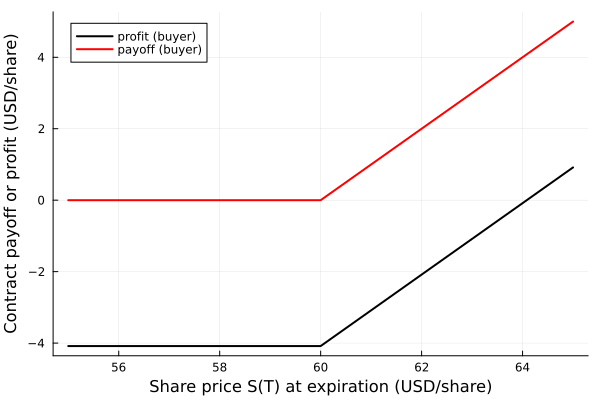

In [8]:
let
    
    call_contract_model.premium = P;
    
    S_array = range(55.0,step=0.1,stop = 65.0) |> collect;
    payoff_array = payoff([call_contract_model], S_array);
    profit_array = profit([call_contract_model], S_array);
    
    plot(profit_array[:,1],profit_array[:,2], c=:black, label="profit (buyer)", lw=2)
    plot!(payoff_array[:,1],payoff_array[:,end], c=:red, label="payoff (buyer)", lw=2)
    xlabel!("Share price S(T) at expiration (USD/share)",fontsize=18)
    ylabel!("Contract payoff or profit (USD/share)",fontsize=18)
end

### Breakeven
The breakeven point for `call` contract is the strike price minus the cost of the contract:

$$\mathcal{B}_{c} = \mathcal{P}_{c}(K,S(0)) + K$$

The break-even price for the European `call` contract is given by:

In [9]:
breakeven_european_put = P + K;
println("The Breakeven for the European call contract is: B = $(breakeven_european_put) USD/share")

The Breakeven for the European call contract is: B = 64.083 USD/share


## Objective 2: Premium, payoff and profit for an American Call contract

We begin our discussion of American style `call` contracts by computing the premium $\mathcal{P}_{c}(K,S(0))$ the buyer must pay for a `call` contract. The key difference between European and American-style contracts is that early exercise is allowed for American-style contracts. Thus, the `call` contract seller may demand a premium that is greater than the European contract because of the possibility of early exercise:

$$\mathcal{P}_{c}(K,S(0)) \geq \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{c}}(K,S(T))\Bigr)$$

The premium of an American style `call` contract is _greater than or equal to_ the expected value of the discounted future payoff. Because exercise can occur at anytime between $0\rightarrow{T}$ we need to simulate the share price $S(t)$ over the time interval, not just at the endpoint like a European contract. We'll use a binomial lattice approximation of the share price over the time interval $0\rightarrow{T}$ in combination with a dynamic programming to compute the contract premium. 

### Bionomial lattice model of Cox, Ross and Rubinstein
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the spot rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$. Different models can be developed for the specific values of the tuple $(u,d,p)$. One particular model is the Cox, Ross, and Rubinstein (CRR) model:

* [Cox, J. C.; Ross, S. A.; Rubinstein, M. (1979). "Option pricing: A simplified approach". Journal of Financial Economics. 7 (3): 229. CiteSeerX 10.1.1.379.7582. doi:10.1016/0304-405X(79)90015-1](https://www.sciencedirect.com/science/article/pii/0304405X79900151?via%3Dihub)

The [CRR binomial lattice model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) was initially developed for options pricing in 1979. However, one of the critical aspects of estimating an option’s price is calculating the underlying asset’s share price. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model, the `up` and `down` moves are symmetric:

$$ud = 1$$

where the magnitude of an `up` move $u$ is given by:

$$u = \exp(\sigma\sqrt{\Delta{T}})$$

The quantity $\sigma$ denotes a _volatility parameter_, and $\Delta{T}$ represents the time step. The probability $p$ of an `up` move in a [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) is given by:

$$p = \frac{\exp(\bar{r}\Delta{T}) - d}{u - d}$$

where $\bar{r}$ denotes a _return parameter_. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model paradigm, the return parameter $\mu$ and the volatility parameter $\sigma$ take on common values:
* The return parameter is a _risk-free_ rate of return; the _risk-free_ rate $\bar{r}$ can be approximated by the [yield on T = 10-year United States Treasury debt security](https://ycharts.com/indicators/10_year_treasury_rate). 
* The volatility parameter $\sigma$ is the [implied volatility](https://www.investopedia.com/terms/i/iv.asp); the implied volatility is the market's view of the likelihood of changes in a given security's price.

Let's consider an American style contract with the same parameters as the previous European contract, expect that early exercise is now allowed.
To start this calculation, we first build an instance of the `MyAdjacencyBasedCRREquityPriceTree` type which holds the parameters and data for the binomial price tree using the `build(...)` function. We store this in the `treemodel` variable:

In [10]:
treemodel = build(MyAdjacencyBasedCRREquityPriceTree, μ = r̄, h = 365, T = T, σ = σ̄, Sₒ = Sₒ);

Next, let's create an instance of the `MyAmericanCallContractModel` type which holds the data for the contract information using the `build(...)` method. We store this instance in the `american_call_contract_model` variable:

In [11]:
american_call_contract_model = build(MyAmericanCallContractModel, (
        K = K, IV = σ̄, DTE = T, sense = 1));

Finally, we can compute the premium for this `call` contract by passing the `treemodel` instance (which holds the risk-neutral simulation of the share price) and the `american_call_contract_model` instance (holds contract information) to the `premium(...)` function:

In [12]:
P_american_CRR = premium(american_call_contract_model, treemodel) |> x-> round(x,sigdigits=5)
println("The premium for the American call contract is: $(P_american_CRR) USD/share")

The premium for the American call contract is: 4.084 USD/share


The _risk premium_ (cost associated with taking on the additional risk) that is demanded by the `seller` of this `call` contract is near zero:

In [13]:
risk_premium = (P_american_CRR - P) |> x-> round(x, sigdigits = 6)
println("The risk premium for the American put contract is: $(risk_premium) USD/share")

The risk premium for the American put contract is: 0.001 USD/share


### Visualize potential profit for an American `call` option at expiration
Now that we have computed the contract premium, we can compute the potential profit and break even points for the `call` contract. 

* First, let's update the American contract model with the premium that we calculated (we'll use the binomial lattice model price).
* Next, we'll build a range values for share price at expiration $S(T)$, and then compute the payoff and profit arrays using the `payoff(...)` and `profit(...)` functions. These functions take an array of contracts, and array of values for $S(T)$ and the return the payoff and the profit
* Finally, we can plot the share price at expiration $S(T)$ versus the payoff (profit) for the buyer (solid lines) and the seller (dashed lines):

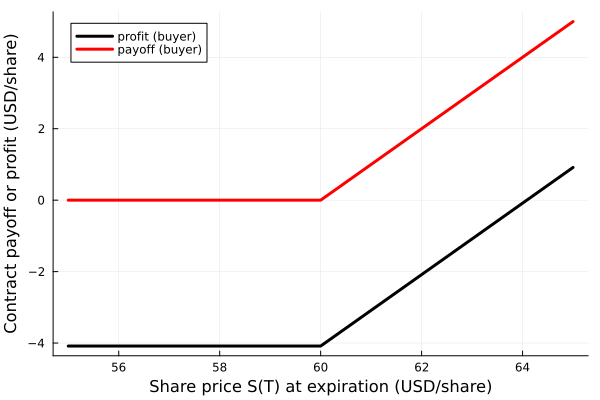

In [23]:
let
    american_call_contract_model.premium = P_american_CRR;
    
    S_array = range(55.0,step=0.1,stop = 65.0) |> collect;
    american_payoff_array = payoff([american_call_contract_model], S_array);
    american_profit_array = profit([american_call_contract_model], S_array);
    
    plot(american_profit_array[:,1], american_profit_array[:,2], c=:black, label="profit (buyer)", lw=3)
    plot!(american_payoff_array[:,1], american_payoff_array[:,end], c=:red, label="payoff (buyer)", lw=3)
    xlabel!("Share price S(T) at expiration (USD/share)",fontsize=18)
    ylabel!("Contract payoff or profit (USD/share)",fontsize=18)
end

### What is the difference between the payoff/profit for an American versus European `call` contract?
The payoff curves for the American and European `call` contracts are the same, but the profit curves _may_ differ if the risk premium (the difference in the cost of the American versus European contracts) is non-zero. In this case, given the contract parameters, the risk premium is near zero. Thus, the profit diagram will be the simular between the contract styles.

### Breakeven

In [15]:
breakeven_american_call = K + P_american_CRR;
println("The breakeven for the American call contract is: B = $(breakeven_american_call) USD/share")

The breakeven for the American call contract is: B = 64.084 USD/share


## Objective 3: Least-Squares Monte Carlo Method of Longstaff and Schwartz

The Longstaff and Schwartz Least Squares method (LSM) is a technique used to estimate the premium of an American-style options contract. It involves simulating a risk-neutral geometric Brownian motion of the underlying share price to generate a range of possible future prices. Backward-induction is then used to estimate the premium of the options contract. 

During each time step, the LSM approach estimates a local regression model of the share price (X) versus the discounted payoff of the contract (Y) to approximate conditional expectation $\mathbb{E}(Y|X)$. This means that it predicts the expected future payoff given the current share price. A decision is then made based on the predicted payoff: 

* If the current payoff is greater than the expected future payoff computed from $\mathbb{E}(Y|X)$, the contract holder exercises the contract now.
* If the current payoff is less than the expected future payoff, the contract holder continues to hold the contract.

This calculation is performed for each path in the collection of sample paths computed by the geometric Brownian motion model. The final contract price is then calculated as the average over all the sample paths. The LSM method was introduced by Longstaff and Schwartz in their paper:


* [Longstaff, F.A.; Schwartz, E.S. (2001). "Valuing American options by simulation: a simple least squares approach". Review of Financial Studies. 14: 113–148. CiteSeerX 10.1.1.155.3462. doi:10.1093/rfs/14.1.113.](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf)

#### Implementation
Let's use this approach to simulate the premium of American-style `put` contracts as a function of the strike price `K`. We downloaded the options chain for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) from [barchart.com](https://www.barchart.com). Currently, the share of `AMD` is $S_{\circ}$ = 117.50 USD/share, and the average implied volatility for `AMD` options with `DTE = 31 days` is `IV = 51.75%`.


We load the options data using using the `loadoptionsdata(...)` function and store in the `options_dataset` variable:

In [16]:
options_dataset = loadoptionsdata()

Row,Strike,Bid,Midpoint,Ask,Last,AVGIV,IV,Type,Time
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7
1,35,82.45,83.03,83.6,79.5,0.5175,2.3033,Call,7/12/23
2,40,77.5,77.95,78.4,48.5,0.5175,1.8801,Call,4/28/23
3,45,72.85,73.15,73.45,69.9,0.5175,1.2223,Call,7/12/23
4,50,67.85,68.13,68.4,71.0,0.5175,1.4811,Call,7/14/23
5,55,62.85,63.18,63.5,61.08,0.5175,0.8203,Call,7/14/23
6,60,57.9,58.18,58.45,57.1,0.5175,1.1983,Call,7/18/23
7,65,52.95,53.25,53.55,52.66,0.5175,0.8171,Call,7/18/23
8,70,47.9,48.25,48.6,46.79,0.5175,0.6489,Call,7/14/23
9,75,43.05,43.33,43.6,43.01,0.5175,0.6885,Call,7/18/23


Next, let's set constant values for the `call` contracts (these values are the same for each strike price `K`). The time will be calendar days `Δt = 1/365`, the initial share price `Sₒ` is 117.50 USD/share, the days to expiration or `DTE` is `31` days, the annual risk-free rate is `r̄ = 0.0418` and the (average) implied volatility `IV = 51.75%`.

In [17]:
Δt = (1.0/365.0);
Sₒ = 117.50;
DTE = 31.0*Δt;
r̄ = 0.0418;
IV = 0.5175;

We construct an instance of the `MyGeometricBrownianMotionEquityModel` type, which holds values associated with the underlying price simulation. We store this data in the `gbm_model` variable:

In [18]:
gbm_model = build(MyGeometricBrownianMotionEquityModel, (
    μ = r̄, σ = IV
));

We sample the geometric Brownian motion model (compute `number_of_paths` sample paths) using the `sample(...)` function. The sample paths are stored in the array `X`:

In [19]:
X = sample(gbm_model, (
    T₁ = 0.0, T₂ = T, Δt = Δt, Sₒ = Sₒ
), number_of_paths = 1000);

We create an instance of the `MyLongstaffSchwartzContractPricingModel` type, which holds a modified sample paths array `Ŝ` (we remove the time column and the initial share price, and transpose the array so that the sample paths are on the rows, time is along the columns). We store the Longstaff model in the `longstaff_model` variable:

In [20]:
Ŝ = X[:,3:end] |> x-> Matrix(transpose(x)) |> x -> x[:,2:end]
longstaff_model = build(MyLongstaffSchwartzContractPricingModel, (
    S = Ŝ, r̄ = r̄, Δt = Δt
));

We calculate the premium for various strike prices, ranging from `K=60` to `K=160`, and record the estimated premium in the `df_LSM_simulation` DataFrame. For each strike price:

* We first check if there is an existing `IV` value in the dataset. If there is, we use that `IV` value. Otherwise, we use the average value for the implied volatility, `IV = 0.5175`. 
* Then, we use the `build(…)` method to create an instance of the `MyAmericanCallContractModel` type, which contains information about the contract. This is stored in the `call_contract_model` variable. Finally, we calculate the premium for this contract using the `premium(…)` function.

In [21]:
start_strike = 60.0;
stop_strike = 160.0;
KA = range(start_strike, stop = stop_strike, step=1) |> collect;
dataset = filter([:Type, :Strike] => (x,y)-> x == "Call" && y ∈ KA, options_dataset);
df_LSM_simulation = DataFrame(K=Float64[], premium = Float64[])
for value ∈ KA
    
    # compute the IV - use average IV is not in dataset
    tmp = dataset[dataset.Strike .== value, :IV]
    IV_value = 0.5175;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end

    # contract model -
    call_contract_model = build(MyAmericanCallContractModel, (
        K = value, IV = first(IV_value), DTE = T, sense = 1
    ));

    # call the longstaff code -
    price_value = premium(call_contract_model, longstaff_model)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value
    );
    push!(df_LSM_simulation, results_tuple);
end

#### Visualize
Let's plot the strike price `K` on the horizontal axis and the estimated premium on the vertical axis. 
* The option price simulation fails to capture the prices of options that are `near the money`, i.e., when $S_{\circ}\simeq{K}$, but does capture the prices for `out the money`, i.e., $S_{\circ} \ll {K}$ and `in of the money`, i.e., $S_{\circ}\gg{K}$ contracts:

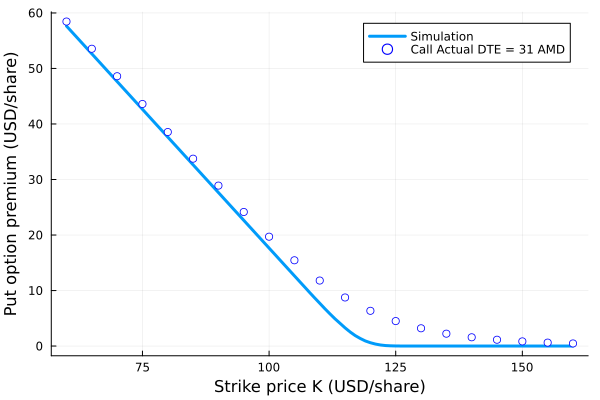

In [24]:
plot(df_LSM_simulation[:,1],df_LSM_simulation[:,2], lw=3, label="Simulation")
scatter!(dataset[:,:Strike], dataset[:,:Ask],label="Call Actual DTE = 31 AMD", mc=:white, msc=:blue)
xlabel!("Strike price K (USD/share)", fontsize=18)
ylabel!("Put option premium (USD/share)", fontsize=18) 